In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

### 1. Define a Function to Create a Real_data Distribution from MNIST datasets :

In [2]:
def real_data(batch_size):
    (x_train,_),(_,_) = mnist.load_data()
    # Reshape the mnist datasets to include a channel :
    x = x_train[:,:,:,np.newaxis]
    # normalize the data in MNIST datasets so they lie between -1 & 1 :
    x = ((x.astype('float32') - 127.5)/127.5)
    # select a batch of images based on batch_size parameter :
    image_batch =  x[np.random.randint(0,x.shape[0],size=batch_size)]
    return image_batch
    

In [3]:
batch = 100

In [4]:
mnist_data = real_data(batch)


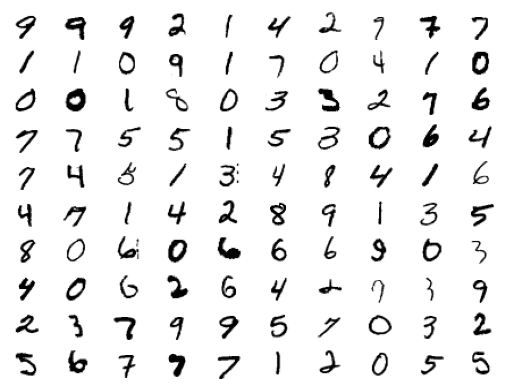

In [5]:
for i in range(10 * 10):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(mnist_data[i,:,:],cmap='gray_r')

#### 2. Create a Function that return a Random Noise data distribution for Generator Model to be fed :

In [6]:
def random_noise(input_features,batch_size):
    data = np.random.uniform(-1,1,size=(batch_size,input_features))
    return data
    

In [7]:
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, Conv2DTranspose

#### 3. create a generator neural netork model : use Upscaling or Transpose Convolution 

In [8]:
def gen_model(input_features):
    model = Sequential()
    model.add(Dense(512,activation='relu',input_dim=input_features))
    model.add(BatchNormalization())
    # 2nd layer :
    model.add(Dense(7*7*64,activation='relu'))
    model.add(BatchNormalization())
    # 3rd layer :
    model.add(Reshape((7,7,64)))
    model.add(Conv2DTranspose(32,kernel_size=(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(BatchNormalization())
    # 4th layer :
    model.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same',activation='tanh'))
    return model
    
    

#### 4. Output of the generator : Fake data distribution :

In [9]:
def output_gen_model(gen_model,batch_size,input_features):
    data_gen = random_noise(input_features,batch_size)
    predict_dist = gen_model.predict(data_gen)
    return predict_dist

#### 5. Create the Discriminator model : It will classify weather the images distribution is fake or real

In [10]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import LeakyReLU

In [11]:
def discremintor_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',activation=LeakyReLU(0.2),input_shape=(28,28,1)))
    model.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same',activation=LeakyReLU(0.2)))
    model.add(Flatten())
    model.add(Dense(512,activation=LeakyReLU(0.2)))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
    return model

In [12]:
batch = 128
input_feat = 100


#### 6. Summery of Generator & Discriminator Network :

In [13]:
Generator = gen_model(input_features=input_feat)

In [14]:
Generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3136)              1608768   
                                                                 
 batch_normalization_1 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       5

In [15]:
Discreminator = discremintor_model()

In [16]:
Discreminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1606144   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,658,753
Trainable params: 1,658,753
Non-trainable params: 0
_________________________________________________________________


#### 7. Data distribution - Generated by Generator :

In [17]:
gen_data = output_gen_model(gen_model=Generator,batch_size=batch,input_features=input_feat)

4/4 [==============================] - 6s 7ms/step


In [18]:
gen_data.shape

(128, 28, 28, 1)

#### 8. Plotting the Fake Sample - Generated by Generator

Text(0.5, 0, 'Fake sample Image')

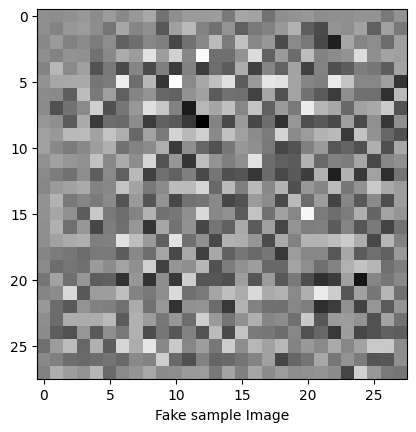

In [19]:
plt.imshow(gen_data[1,:,:,0],cmap='gray_r')
plt.xlabel("Fake sample Image")

#### 9. Create a GAN wrapper function that conatins both Generator & Distriminator Model :

In [20]:
def GAN(gen_model,dis_model):
    dis_model.trainable = False
    model = Sequential()
    model.add(gen_model)
    model.add(dis_model)
    model.compile(loss='binary_crossentropy',optimizer='adam')
    return model
    

In [21]:
gan_model = GAN(gen_model=Generator,dis_model=Discreminator)

#### 10. Train the GAN model & Discriminator model simultaneously :

In [22]:
nEpochs = 5000


In [23]:
for i in range(nEpochs):
    # real_data :
    x_real_data = real_data(batch)
    # fake data generated by generator :
    x_fake_data = output_gen_model(Generator,batch,input_feat)
    # concatenate both Real & Fake data :
    X = np.concatenate([x_real_data,x_fake_data])
    Y = np.zeros(batch * 2)
    Y[:batch] = 1
    # Train the DISC Model on Real dataset :
    Discreminator.train_on_batch(X,Y)
    # Train generator model :
    data_gen_x = random_noise(input_feat,batch*2)
    # create label for the fake data as 1 to fool Discriminator:
    data_gen_y = np.ones((batch*2,1))
    # train the Generator model through GAN function:
    gan_model.train_on_batch(data_gen_x,data_gen_y)
    if (i) % 50 == 0:
        x_real_test = real_data(10)
        x_fake_test = output_gen_model(Generator,10,input_feat)
        x_test = np.concatenate([x_real_data,x_fake_test])
        y_test = np.zeros(10*2)
        y_test[:10] = 1
        predict_test = Discreminator.predict(x_test)
        print(f"Discriminator test Probability : {np.mean(predict_test)}")
        x_fake = output_gen_model(Generator,batch,input_feat)
       
    
    
    
    

5/5 [==============================] - 0s 11ms/step
Discriminator test Probability : 0.9028908610343933
5/5 [==============================] - 0s 4ms/step
Discriminator test Probability : 0.9275369048118591
5/5 [==============================] - 0s 3ms/step
Discriminator test Probability : 0.9275393486022949
5/5 [==============================] - 0s 4ms/step
Discriminator test Probability : 0.8928084373474121
5/5 [==============================] - 0s 2ms/step
Discriminator test Probability : 0.910251259803772
5/5 [==============================] - 0s 2ms/step
Discriminator test Probability : 0.8442239165306091
5/5 [==============================] - 0s 2ms/step
Discriminator test Probability : 0.7431859374046326
5/5 [==============================] - 0s 3ms/step
Discriminator test Probability : 0.7418294548988342
5/5 [==============================] - 0s 4ms/step
Discriminator test Probability : 0.7250328660011292
5/5 [==============================] - 0s 5ms/step
Discriminator test Pro

In [24]:
print("Hello")

Hello


1/1 [==============================] - 0s 26ms/step


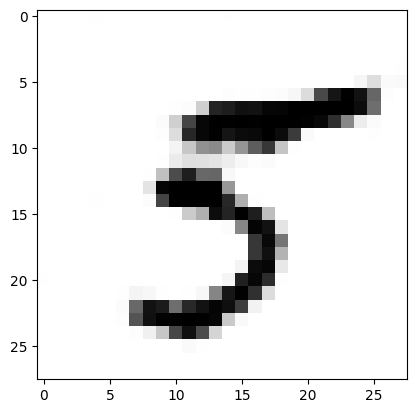

In [40]:
x_fake_dist = output_gen_model(Generator,25,input_feat)
# Visualizing the plots
for j in range(5*5):
    # plt.subplot(5,5,j+1)
    # # turn off axis 
    # plt.axis('off')
    plt.imshow(x_fake_dist[j,:,:,0],cmap='gray_r')